<a href="https://colab.research.google.com/github/harshitharavi26/PP2/blob/main/Proto_doc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Cuda

In [ ]:
#Setting environment variables using os.environ. This is done before initializing TensorFlow to limit TensorFlow to first GPU.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

In [ ]:
#displays the installed GPU stats
!nvidia-smi

In [ ]:
#Checking the current CUDA compiler version
!nvcc --version

In [ ]:
#Uninstall the current CUDA version
!apt-get --purge remove cuda nvidia* libnvidia-*
!dpkg -l | grep cuda- | awk '{print $2}' | xargs -n1 dpkg --purge
!apt-get remove cuda-*
!apt autoremove
!apt-get update

In [ ]:
#Downloading CUDA 10.0
!wget  --no-clobber https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
#Installing CUDA kit dpkg
!dpkg -i cuda-repo-ubuntu1804_10.0.130-1_amd64.deb
!sudo apt-key adv --fetch-keys https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/7fa2af80.pub
!apt-get update
!apt-get install cuda-10-0

In [ ]:
#After changing version of CUDA from 10.2 to 10.0
!nvcc --version

In [ ]:
#Check GPU support, please do activate GPU
print(torch.cuda.is_available())

In [ ]:
#To determine the version of cuDNN
torch.backends.cudnn.version()

In [ ]:
#To check if CUDNN is currently available.
torch.backends.cudnn.is_available()

# **Prototypical Network**


##Importing

Pytorch, Numpy

In [1]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import Activation
from keras.layers import Input, Lambda, Dense, Dropout, Convolution2D, MaxPooling2D, Flatten
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from imutils import paths
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import multiprocessing as mp
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Reading train data

In [3]:
def read_emotions(emotion_directory_path, emotion_directory_name):
    """
    Reads all the images from a given emotion_directory
    """
    data = [] #Storing images
    labels = [] #Storing labels
    images_dir = os.listdir(emotion_directory_path) #/content/drive/My Drive/DatasetPP2/e1/
    for img in images_dir:# Images stored in e1
      if (int(img.split(".")[0])<31):#Take only 30 images for training
        image = cv2.resize(
            cv2.cvtColor(cv2.imread(emotion_directory_path+img),cv2.COLOR_BGR2RGB),
            (256,256)
             )#imread reads the image in BGR which is then converted to RGB and resized to (256,256)

        #Data Augmentation
        rotated_90 = ndimage.rotate(image, 90)
        rotated_180 = ndimage.rotate(image, 180)
        rotated_270 = ndimage.rotate(image, 270)
        #Rotate the image with angles 90,180 and 270

        data.extend((image, rotated_90, rotated_180, rotated_270)) #The original and rotated images are added to the data list
        labels.extend((
                emotion_directory_name + '_0', #e1_0
                emotion_directory_name + '_90',#e1_90
                emotion_directory_name + '_180',#e1_180
                emotion_directory_name + '_270'#e1_270
            ))
    # All images in e1 rotated at 90 will have the label e1_90
    # Hence every emotion(e1,e2,e3,e4,e5) will have 4 different classes
    # 5 emotions * 4 classes per emotion = 20 classes
    return np.array(data), np.array(labels)

In [4]:
def read_images(base_directory):
    """
    Reads all the emotions from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    images = None
    labels = None
    pool = mp.Pool(mp.cpu_count())# Multiprocessing 
    #cpu_count() gives maximum number of processes we can run at any given moment 
    #Pool class distributes the tasks to the worker processes and collects the return values in the form of a list(FIFO)
    results = [pool.apply(read_emotions,
                          args=(
                              base_directory +'/'+ directory + '/', directory, 
                              )) for directory in os.listdir(base_directory)] #directory = e1,e2,e3,e4,e5
    #pool.apply maintains an ordered list of results
    pool.close() #We cannot submit new tasks to our pool of worker processes
    for result in results: #results contain [data,labels] for every emotion
        if images is None:
            images = result[0]#stores the data of the first emotion
            labels = result[1]#stores the labels of the first emotion
        else:
            images = np.vstack([images, result[0]])#Stacks arrays in sequence vertically(row wise)
            #array([[...],[...],[...]])
            labels = np.concatenate([labels, result[1]])
    return images, labels

In [5]:
dir = '/content/drive/My Drive/DatasetPP2'

In [6]:
%%time
trainx, trainy = read_images(dir)
#trainx contains all images required for training
#trainy contains the corresponding labels

CPU times: user 150 ms, sys: 175 ms, total: 325 ms
Wall time: 1min 1s


In [7]:
trainx.shape, trainy.shape
#20 classes * 30 images per class = 600 images

((600, 256, 256, 3), (600,))

## Extracting sample images

In [8]:
def extract_image(n_classes, n_support, n_query, images, labels):
  """
  Picks random sample of size n_support+n_querry, for n_classes classes
  Args:
      n_classes (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      images (np.array): dataset of images
      labels (np.array): dataset of labels
  Returns:
      (dict) of:
        (torch.Tensor): sample of images. Size (n_classes, n_support+n_query, (dim))
        (int): n_classes
        (int): n_support
        (int): n_query
  Example: 
        Take n_classes = 5, n_support = 3, n_query = 3
  """
  sample = []
  final_label=[]
  K = np.random.choice(np.unique(labels), n_classes, replace=False) #np.unique(labels)=20 i.e 20 unique classes
  #Hence from 20 classes it randomly choose 5 classes without replacement
  for cls in K:
    final_label.append(cls)
    images_cls = images[labels == cls] #images_cls contains all the images from the particular class(for example all images of e1_90)
    perm = np.random.permutation(images_cls) #reorganises the images in the class
    sample_cls = perm[:(n_support+n_query)] #From the 30 images of the class, it extracts 6 images(n_support+n_query)
    sample.append(sample_cls)# sample list contains 6 images from each of the 5 classes
  sample = np.array(sample)#converts it into a numpy array(ndarray)
  sample = torch.from_numpy(sample).float()#converts the ndarray into a tensor. Tensors are generalised vectors. Similar to multidimensional array
  #sample tensor will have shape (5,6,256,256,3)
  sample = sample.permute(0,1,4,2,3)#rearranges the original tensor according to the designed ordering
  #After reordering sample will have shape (5,6,3,256,256)
  return({
      'images': sample,
      'n_classes': n_classes,
      'n_support': n_support,
      'n_query': n_query,
      'final_label':final_label
      })

In [9]:
def display(sample):
  """
  Displays sample in a grid
  Args:
      sample (torch.Tensor): sample of images to display
  """
  #need 4D tensor to create grid, currently 5D
  sample_4D = sample.view(sample.shape[0]*sample.shape[1],*sample.shape[2:])
  #make a grid
  out = torchvision.utils.make_grid(sample_4D, nrow=sample.shape[1],range=(0,255),normalize=True)
  plt.figure(figsize = (20,10))
  plt.imshow(out.permute(1, 2, 0))

['e3_180', 'e5_90', 'e4_180', 'e4_0', 'e4_270']


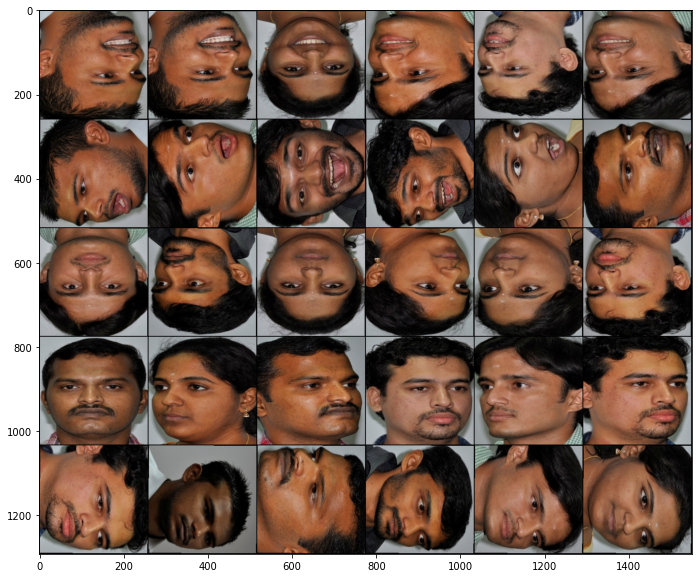

In [10]:
example = extract_image(5, 3, 3, trainx, trainy)
display(example['images'])
print(example['final_label'])

In [11]:
example['images'].shape

torch.Size([5, 6, 3, 256, 256])

## Building Prototypical network

Unlike typical deep learning architecture, prototypical networks do not classify the image directly, and instead learn the mapping of an image in metric space.
An encoder maps an image into a vector in the embedding space. Support images are used to define the prototype. Distances between prototypes and encoded query images are used to classify them.
The main advantage of working in that embedding space is that two images that look the same will be close to each other, and two images that are completely different will be far away

In [12]:
class Flatten(nn.Module):
  def __init__(self):
    super(Flatten, self).__init__()

  def forward(self, x):
    return x.view(x.size(0), -1)

In [13]:
#Basically. you pass your images through a CNN (the encoder) with decreasing layer size. 
#The last layer of this network is the one that produce the embeddings (that is, a lower dimensional representation of your input)
#The number of neurons you use here is the length of your vector embedding for the input images
def load_protonet_conv(**kwargs):
  """
  Loads the prototypical network model
  Arg:
      x_dim (tuple): dimension of input image
      hid_dim (int): dimension of hidden layers in conv blocks
      z_dim (int): dimension of embedded image
  Returns:
      Model (Class ProtoNet)
  """
  x_dim = kwargs['x_dim']
  hid_dim = kwargs['hid_dim']
  z_dim = kwargs['z_dim']

  #Image2Vector CNN architecture
  # 4 modules or blocks are present
  # Each block consists of a CNN layer followed by batch normalization, then by a ReLu activation function which leads into a max pool layer.
  def conv_block(in_channels, out_channels):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, 3, padding=1),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(),
        nn.MaxPool2d(2)
        )
  # 4 blocks
  encoder = nn.Sequential(
    conv_block(x_dim[0], hid_dim), #conv_block(3,64)
    conv_block(hid_dim, hid_dim), #conv_block(64,64)
    conv_block(hid_dim, hid_dim), #conv_block(64,64)
    conv_block(hid_dim, z_dim), #conv_block(64,64)
    Flatten()
    )
  #After all the blocks, the remaining output is flattened and returned as a result.
  
  return ProtoNet(encoder)

In [14]:
class ProtoNet(nn.Module):
  def __init__(self, encoder):
    """
    Args:
        encoder : CNN encoding the images in sample
        n_classes (int): number of classes in a classification task
        n_support (int): number of labeled examples per class in the support set
        n_query (int): number of labeled examples per class in the query set
    """
    super(ProtoNet, self).__init__()
    self.encoder = encoder.cuda()
                  #nn.Sequential(
    #conv_block(x_dim[0], hid_dim), c#onv_block(3,64)
    #conv_block(hid_dim, hid_dim), #conv_block(64,64)
    #conv_block(hid_dim, hid_dim), #conv_block(64,64)
    #conv_block(hid_dim, z_dim), #conv_block(64,64)
    #Flatten()
    #)

  def set_forward_loss(self, sample):
    """
    Computes loss, accuracy and output for classification task
    Args:
        sample (torch.Tensor): shape (n_classes, n_support+n_query, (dim)) 
    Returns:
        torch.Tensor: shape(2), loss, accuracy and y_hat
    """
    sample_images = sample['images'].cuda()
    n_classes = sample['n_classes']
    n_support = sample['n_support']
    n_query = sample['n_query']

    x_support = sample_images[:, :n_support]#extracts the support set of images from the sample
    x_query = sample_images[:, n_support:]#extracts the query set of images from the sample
   
    #target indices are 0 ... n_classes-1
    target_inds = torch.arange(0, n_classes).view(n_classes, 1, 1).expand(n_classes, n_query, 1).long()
    #arange eturns a 1D tensor that has all the values within the specified range. 
    #View is used to reshape the tensor
    #expand is used to expand the tensor to larger number of dimensions
    target_inds = Variable(target_inds, requires_grad=False)
    #Variable is a wrapper around pytorch tensor
    target_inds = target_inds.cuda()
   
    #encode images of the support and the query set
    x = torch.cat([x_support.contiguous().view(n_classes * n_support, *x_support.size()[2:]),
                   x_query.contiguous().view(n_classes * n_query, *x_query.size()[2:])], 0)
   
    z = self.encoder.forward(x)
    z_dim = z.size(-1) #usually 64
    z_proto = z[:n_classes*n_support].view(n_classes, n_support, z_dim).mean(1)#To find the prototype of the class
    #mean(1) - axis = 1 means working along the row
    z_query = z[n_classes*n_support:]

    #compute distances
    dists = euclidean_dist(z_query, z_proto)
    
    #compute probabilities
    log_p_y = F.log_softmax(-dists, dim=1).view(n_classes, n_query, -1)
   
    loss_val = -log_p_y.gather(2, target_inds).squeeze().view(-1).mean()
    _, y_hat = log_p_y.max(2)
    acc_val = torch.eq(y_hat, target_inds.squeeze()).float().mean()
   
    return loss_val, {
        'loss': loss_val.item(),
        'acc': acc_val.item(),
        'y_hat': y_hat
        }

In [15]:

def euclidean_dist(x, y):
  """
  Computes euclidean distance btw x and y
  Args:
      x (torch.Tensor): shape (n, d). n usually n_classes*n_query
      y (torch.Tensor): shape (m, d). m usually n_classes
  Returns:
      torch.Tensor: shape(n, m). For each query, the distances to each centroid
  """
  n = x.size(0)
  m = y.size(0)
  d = x.size(1)
  assert d == y.size(1)

  x = x.unsqueeze(1).expand(n, m, d)
  y = y.unsqueeze(0).expand(n, m, d)

  return torch.pow(x - y, 2).sum(2)

## Training

In [16]:
from tqdm import tqdm_notebook
from tqdm import tnrange

In [17]:
def train(model, optimizer, train_x, train_y, n_classes, n_support, n_query, max_epoch, epoch_size):
  """
  Trains the protonet
  Args:
      model
      optimizer
      train_x (np.array): images of training set
      train_y(np.array): labels of training set
      n_classes (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      max_epoch (int): max epochs to train on
      epoch_size (int): episodes per epoch
  """
  #divide the learning rate by 2 at each epoch, as suggested in paper
  scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.5, last_epoch=-1)
  epoch = 0 #epochs done so far
  stop = False #status to know when to stop

  while epoch < max_epoch and not stop:
    running_loss = 0.0
    running_acc = 0.0

    for episode in tnrange(epoch_size, desc="Epoch {:d} train".format(epoch+1)):
      #  In each episode, we select Nc classes at random from the training set. For each class, we randomly sample Ns images.
      # Another randomly sampled Nq images are obtained which belongs to the query set
      sample = extract_image(n_classes, n_support, n_query, train_x, train_y)
      optimizer.zero_grad() #Initializes the value of gradients to 0
      loss, output = model.set_forward_loss(sample)
      running_loss += output['loss']
      running_acc += output['acc']
      loss.backward()
      optimizer.step()
    epoch_loss = running_loss / epoch_size
    epoch_acc = running_acc / epoch_size
    print('Epoch {:d} -- Loss: {:.4f} Acc: {:.4f}'.format(epoch+1,epoch_loss, epoch_acc))
    epoch += 1
    scheduler.step()

In [18]:
%%time

model = load_protonet_conv(
    x_dim=(3,256,256), #dimension of input image
    hid_dim=64, #dimension of hidden layer
    z_dim=64, #ddimension of embedded image
    )
#model contains the embedded image

optimizer = optim.Adam(model.parameters(), lr = 0.001)

n_classes = 5
n_support = 3
n_query = 3

train_x = trainx
train_y = trainy

max_epoch = 5
epoch_size = 2000 #EPISODE - A training iteration. We train the network once, calculate loss and backpropogate error

train(model, optimizer, train_x, train_y, n_classes, n_support, n_query, max_epoch, epoch_size)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`



Epoch 1 -- Loss: 6.4804 Acc: 0.7106



Epoch 2 -- Loss: 0.3689 Acc: 0.8355



Epoch 3 -- Loss: 0.2695 Acc: 0.8822



Epoch 4 -- Loss: 0.1895 Acc: 0.9225



Epoch 5 -- Loss: 0.1125 Acc: 0.9566
CPU times: user 12min 13s, sys: 6min 57s, total: 19min 11s
Wall time: 19min 14s


## Reading test data

In [19]:
def read_emotions1(emotion_directory_path, emotion_directory_name):
    """
    Reads all the characters from a given alphabet_directory
    """
    data = []
    labels = []
    images = os.listdir(emotion_directory_path)
    for img in images:
      if (int(img.split(".")[0])>30):
        image = cv2.resize(
            cv2.cvtColor(cv2.imread(emotion_directory_path+img),cv2.COLOR_BGR2RGB),
            (256,256)
             )
            #rotations of image
        rotated_90 = ndimage.rotate(image, 90)
        rotated_180 = ndimage.rotate(image, 180)
        rotated_270 = ndimage.rotate(image, 270)
        data.extend((image, rotated_90, rotated_180, rotated_270))
        labels.extend((
                emotion_directory_name + '_0',
                emotion_directory_name + '_90',
                emotion_directory_name + '_180',
                emotion_directory_name + '_270'
            ))
    return np.array(data), np.array(labels)

In [20]:
def read_images1(base_directory):
    """
    Reads all the alphabets from the base_directory
    Uses multithreading to decrease the reading time drastically
    """
    data = None
    labels = None
    pool = mp.Pool(mp.cpu_count())
    results = [pool.apply(read_emotions1,
                          args=(
                              base_directory +'/'+ directory + '/', directory, 
                              )) for directory in os.listdir(base_directory)]
    pool.close()
    #print(results)
    for result in results:
        if data is None:
            data = result[0]
            labels = result[1]
        else:
            data = np.vstack([data, result[0]])
            labels = np.concatenate([labels, result[1]])
    return data, labels

In [21]:
%%time 
testx, testy = read_images1(dir)

CPU times: user 59.5 ms, sys: 109 ms, total: 169 ms
Wall time: 23 s


In [22]:
testx.shape,testy.shape

((220, 256, 256, 3), (220,))

## Testing

In [23]:
def test(model, test_x, test_y, n_classes, n_support, n_query, test_episode):
  """
  Tests the protonet
  Args:
      model: trained model
      test_x (np.array): images of testing set
      test_y (np.array): labels of testing set
      n_classes (int): number of classes in a classification task
      n_support (int): number of labeled examples per class in the support set
      n_query (int): number of labeled examples per class in the query set
      test_episode (int): number of episodes to test on
  """
  running_loss = 0.0
  running_acc = 0.0
  for episode in tnrange(test_episode):
    sample = extract_image(n_classes, n_support, n_query, test_x, test_y)
    loss, output = model.set_forward_loss(sample)
    running_loss += output['loss']
    running_acc += output['acc']
  avg_loss = running_loss / test_episode
  avg_acc = running_acc / test_episode
  print('Test results -- Loss: {:.4f} Acc: {:.4f}'.format(avg_loss, avg_acc))

In [24]:
n_classes = 5
n_support = 3
n_query = 2

test_x = testx
test_y = testy

test_episode = 1000

test(model, test_x, test_y, n_classes, n_support, n_query, test_episode)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  from ipykernel import kernelapp as app



Test results -- Loss: 0.3446 Acc: 0.8674



## Testing with a sample

['e3_270', 'e2_90', 'e1_90', 'e1_180', 'e4_90']


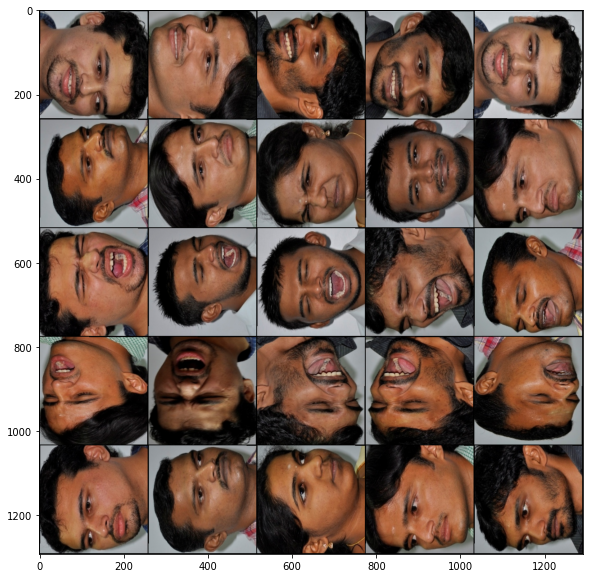

In [25]:
my_sample = extract_image(n_classes, n_support, n_query, test_x, test_y)
display(my_sample['images'])
print(my_sample['final_label'])

In [26]:
my_loss, my_output = model.set_forward_loss(my_sample)

In [27]:
my_output

{'acc': 0.800000011920929, 'loss': 0.2968360483646393, 'y_hat': tensor([[0, 0],
         [4, 4],
         [2, 2],
         [3, 3],
         [4, 4]], device='cuda:0')}

In [28]:
y_val = my_output['y_hat']
print(y_val)

tensor([[0, 0],
        [4, 4],
        [2, 2],
        [3, 3],
        [4, 4]], device='cuda:0')


In [29]:
print(y_val[0])
y_new1=[[0 for i in range(len(y_val[0]))]for j in range(len(y_val))]
for i in range(len(y_val)):
  for j in range(len(y_val[0])):
    y_new1[i][j]=my_sample['final_label'][i]
print(y_new1)

tensor([0, 0], device='cuda:0')
[['e3_270', 'e3_270'], ['e2_90', 'e2_90'], ['e1_90', 'e1_90'], ['e1_180', 'e1_180'], ['e4_90', 'e4_90']]


In [30]:
print(y_val[0])
y_new=[[0 for i in range(len(y_val[0]))]for j in range(len(y_val))]
print(len(y_new))
for i in range(len(y_val)):
  for j in range(len(y_val[0])):
    y_new[i][j]=my_sample['final_label'][y_val[i][j]]
print(y_new)

tensor([0, 0], device='cuda:0')
5
[['e3_270', 'e3_270'], ['e4_90', 'e4_90'], ['e1_90', 'e1_90'], ['e1_180', 'e1_180'], ['e4_90', 'e4_90']]


In [31]:
print(y_new1)#Actual
print(y_new)#Predicted

[['e3_270', 'e3_270'], ['e2_90', 'e2_90'], ['e1_90', 'e1_90'], ['e1_180', 'e1_180'], ['e4_90', 'e4_90']]
[['e3_270', 'e3_270'], ['e4_90', 'e4_90'], ['e1_90', 'e1_90'], ['e1_180', 'e1_180'], ['e4_90', 'e4_90']]
